In [1]:
import pandas as pd
from pandas.plotting import scatter_matrix
import os
from datetime import datetime
import sqlite3
from sqlalchemy import create_engine
engine = create_engine('sqlite://', echo=False)

import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.inspection import plot_partial_dependence
from sklearn.inspection import partial_dependence 
from sklearn.metrics import classification_report, roc_curve, roc_auc_score, auc
import dill as pickle
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.inspection import plot_partial_dependence
from sklearn.metrics import log_loss, mean_squared_error
from sklearn.covariance import EmpiricalCovariance
from sklearn.preprocessing import label_binarize

import cleaning as clean

%matplotlib inline

ModuleNotFoundError: No module named 'cleaning'

In [2]:
sampleall = pd.read_pickle("data/df_ready_to_split_to_X_y_no_day.pkl")

sa = sampleall.copy(deep=True)

X = sampleall.drop("Force_Level", axis=1)
y = sampleall.Force_Level

cols = X.columns

In [4]:
sampleall.info(verbose=True)


<class 'pandas.core.frame.DataFrame'>
Index: 2047618 entries, 0 to 3986667
Data columns (total 170 columns):
Force_Level                                             int64
P_EAST                                                  uint8
P_NORTH                                                 uint8
P_SOUTH                                                 uint8
P_SOUTHWEST                                             uint8
P_WEST                                                  uint8
S_BOY                                                   uint8
S_CHARLIE                                               uint8
S_DAVID                                                 uint8
S_EDWARD                                                uint8
S_FRANK                                                 uint8
S_GEORGE                                                uint8
S_JOHN                                                  uint8
S_KING                                                  uint8
S_LINCOLN              

## probably start here with loading the df from right before dummies in EDA


In [101]:
nm = pd.read_pickle("data/rev_df_before_dummies.pkl")

# need to:
# make a y and make categories numeric(?)
# drop CAD and Event and Force
# make dummie columns
# cahnge month and day to integers


In [102]:
nm.columns

Index(['CAD_Event_Number', 'Force_Level', 'Precinct', 'Sector', 'Beat',
       'Subject_Race', 'Subject_Gender', 'Call_Type', 'Initial_Call_Type',
       'month', 'day', 'day_of_week', 'hour'],
      dtype='object')

In [103]:
nm.Precinct.replace({'W': "WEST", "N": "NORTH", "E": "EAST", "S": "SOUTH", "SW":"SOUTHWEST"}, inplace=True)



In [104]:
nm["hour2"] = nm.hour.apply(lambda x: (x/24)*2*np.pi)
nm["sin_hour2"] = nm.hour2.apply(np.sin)
nm["cos_hour2"] = nm.hour2.apply(np.cos)
nm.drop(["hour2","hour"], axis=1, inplace=True)

In [105]:
# make a copy to alter for the model in case I want to look back at this
nm2 = nm.copy(deep=True)

In [106]:
# drop column 
nm.drop( "CAD_Event_Number", axis=1, inplace=True)


In [107]:
# do you want to drop this columns??

# STOP!!

nm.drop( "day", axis=1, inplace=True)

In [108]:
nm.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Index: 2047618 entries, 0 to 3986667
Data columns (total 12 columns):
Force_Level          object
Precinct             object
Sector               object
Beat                 object
Subject_Race         object
Subject_Gender       object
Call_Type            object
Initial_Call_Type    object
month                int64
day_of_week          int64
sin_hour2            float64
cos_hour2            float64
dtypes: float64(2), int64(2), object(8)
memory usage: 203.1+ MB


In [109]:
# calling above function to make list to make column
new_col = []
for idx, row in nm.iterrows():
    value = row.Initial_Call_Type
    new_col.append(clean.initial_call_type_cats(value))
    
nm["cat_ICT"] = new_col

# make copy so you don't repeat this ... AGAIN
nm_cat_ICT = nm.copy(deep=True)

nm.drop("Initial_Call_Type", axis=1, inplace=True)

In [111]:
nm.to_pickle("nm_cat_nodumdum")

In [50]:
# get dummies for string valued columns
nm = pd.get_dummies(data = nm, 
                     columns=["Precinct", "Sector", "Beat", "Subject_Gender", "Subject_Race", "Call_Type", 
                               "cat_ICT", "day_of_week", "month"], 
                     prefix=["P",  "S", "B", "SG", "SR","CT", "ICT", "dow", "month"])

nm.drop(["S_-", "P_-", 'SG_-', 'SR_-', 'P_X', "ICT_-"], axis=1, inplace=True)

In [53]:
# numeric y

nm.Force_Level.replace({"Level 1 - Use of Force":1,"Level 2 - Use of Force":2,"Level 3 - OIS":4, "Level 3 - Use of Force": 3 }, inplace=True)


In [736]:
'''# undersampling / oversampling
four = nm[nm["Force_Level"] == 4]
three = nm[nm["Force_Level"] == 3]
two = nm[nm["Force_Level"] == 2]
one = nm[nm["Force_Level"] == 1]
zero = nm[nm["Force_Level"] == 0]

len(four), len(three), len(two), len(one), len(zero)'''

In [738]:
'''#nm["Weights"] = np.where(nm['Force_Level'] <= 4, .1, .9)

nm["Weights"] = nm["Force_Level"]
nm["Weights"].replace({4:.5, 3:.3, 2:.1105, 1:.08, 0:.0005}, inplace=True)'''

'#nm["Weights"] = np.where(nm[\'Force_Level\'] <= 4, .1, .9)\n\nnm["Weights"] = nm["Force_Level"]\nnm["Weights"].replace({4:.5, 3:.3, 2:.1105, 1:.08, 0:.0005}, inplace=True)'

In [740]:
'''len(sample1[sample1.Force_Level == 4]), len(sample1[sample1.Force_Level == 3]), len(sample1[sample1.Force_Level == 2]), len(sample1[sample1.Force_Level == 1]), len(sample1[sample1.Force_Level == 0])

sample4 = four.sample(n=6000, random_state=659, replace=True)
sample3 = three.sample(n=6000, random_state=659, replace=True)
sample2 = two.sample(n=6000, random_state=659, replace=True)
sample1 = one.sample(n=6000, random_state=659, replace=True)
sample0 = zero.sample(n=6000, random_state=659, replace=True)

sampleall = pd.concat([sample4,sample3, sample2, sample1, sample0])
'''

In [82]:
sampleall = nm.copy(deep=True)

In [86]:
sampleall.drop(['B_DCD',
 'B_DDB',
 'B_DND',
 'B_DWD'], axis=1, inplace=True)

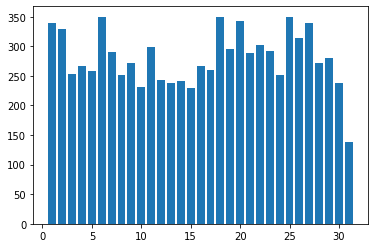

In [953]:
sa = sampleall.groupby("Force_Level").day.value_counts()
plt.bar(sa[1].index, list(sa[1]));
#sa[3].index, list(sa[3])

In [87]:
#sampleall.drop("day", axis=1, inplace=True)
sampleall["S_BOY"] = sampleall["S_BOY"] + sampleall["S_B"]
sampleall["S_CHARLIE"] = sampleall["S_CHARLIE"] + sampleall["S_C"]
sampleall["S_DAVID"] = sampleall["S_DAVID"] + sampleall["S_D"]
sampleall["S_EDWARD"] = sampleall["S_EDWARD"] + sampleall["S_E"]
sampleall["S_FRANK"] = sampleall["S_FRANK"] + sampleall["S_F"]
sampleall["S_GEORGE"] = sampleall["S_GEORGE"] + sampleall["S_G"]

sampleall["S_JOHN"] = sampleall["S_JOHN"] + sampleall["S_J"]
sampleall["S_KING"] = sampleall["S_KING"] + sampleall["S_K"]
sampleall["S_LINCOLN"] = sampleall["S_LINCOLN"] + sampleall["S_L"]
sampleall["S_MARY"] = sampleall["S_MARY"] + sampleall["S_M"]
sampleall["S_NORA"] = sampleall["S_NORA"] + sampleall["S_N"]
sampleall["S_OCEAN"] = sampleall["S_OCEAN"] + sampleall["S_O"]

sampleall["S_QUEEN"] = sampleall["S_QUEEN"] + sampleall["S_Q"]
sampleall["S_ROBERT"] = sampleall["S_ROBERT"] + sampleall["S_R"]
sampleall["S_SAM"] = sampleall["S_SAM"] + sampleall["S_S"]
sampleall["S_UNION"] = sampleall["S_UNION"] + sampleall["S_U"]
sampleall["S_WILLIAM"] = sampleall["S_WILLIAM"] + sampleall["S_W"]



In [88]:
sampleall.drop(["S_W", "S_U","S_S",  "S_R", "S_Q", "S_O","S_N", "S_M", "S_L","S_K", "S_J", "S_G", "S_F",
               "S_E","S_D", "S_C", "S_B"], axis=1, inplace=True)

In [91]:
sampleall.drop(['SG_Not Specified',"SR_Not Specified", "CT_FK ERROR", "S_99", "P_UNKNOWN"], axis=1, inplace=True)


['Force_Level',
 'P_EAST',
 'P_NORTH',
 'P_SOUTH',
 'P_SOUTHWEST',
 'P_WEST',
 'S_BOY',
 'S_CHARLIE',
 'S_DAVID',
 'S_EDWARD',
 'S_FRANK',
 'S_GEORGE',
 'S_JOHN',
 'S_KING',
 'S_LINCOLN',
 'S_MARY',
 'S_NORA',
 'S_OCEAN',
 'S_QUEEN',
 'S_ROBERT',
 'S_SAM',
 'S_UNION',
 'S_WILLIAM',
 'B_99',
 'B_B1',
 'B_B2',
 'B_B3',
 'B_BS',
 'B_C1',
 'B_C2',
 'B_C3',
 'B_CCD',
 'B_CD',
 'B_CDD',
 'B_CMD',
 'B_CMD2',
 'B_COMM',
 'B_CS',
 'B_CTY',
 'B_D1',
 'B_D2',
 'B_D3',
 'B_DBB',
 'B_DBD',
 'B_DCC',
 'B_DET',
 'B_DS',
 'B_DSPV',
 'B_DSPVD',
 'B_E',
 'B_E1',
 'B_E2',
 'B_E3',
 'B_ED',
 'B_EP',
 'B_ES',
 'B_F1',
 'B_F2',
 'B_F3',
 'B_FS',
 'B_G1',
 'B_G2',
 'B_G3',
 'B_GS',
 'B_H2',
 'B_H3',
 'B_HBR',
 'B_HS',
 'B_INV',
 'B_J1',
 'B_J2',
 'B_J3',
 'B_JS',
 'B_K1',
 'B_K2',
 'B_K3',
 'B_KS',
 'B_L1',
 'B_L2',
 'B_L3',
 'B_LAPT',
 'B_LS',
 'B_M1',
 'B_M2',
 'B_M3',
 'B_MS',
 'B_N',
 'B_N1',
 'B_N2',
 'B_N3',
 'B_ND',
 'B_NP',
 'B_NS',
 'B_O1',
 'B_O2',
 'B_O3',
 'B_OD',
 'B_ODD',
 'B_OS',
 'B_Q1',
 'B_

In [92]:

sampleall.drop([  "B_99", "B_CCD","B_CD", "B_CDD",
               "B_CMD", "B_CMD2", "B_COMM", "B_CS","B_CTY", "B_DBB", "B_DBD", "B_DCC", "B_DET", "B_DS", "B_DSPVD",
                "B_E", "B_EP", "B_ED", "B_ES", "B_GS", "B_HS", "B_INV", "B_LAPT",  "B_N", "B_ODD", "B_OS", "B_S", 
                "B_SCTR1", "B_SD", "B_SP","B_JS","B_SPCT", "B_SOUTH",  "B_KS", "B_LS","B_MS", "B_ND", "B_NP", "B_NS", "B_OD", "B_QS", 
               "B_SPVD", "B_SPVDD", "B_SW", "B_SS", "B_SWT", "B_T", "B_TAC2", "B_TAC3", "B_TQ", "B_TRF", "B_W", "B_US","B_W",  "B_WD", 
               "B_WP", "B_WS", "B_XDD"], axis=1, inplace=True)


In [94]:
sampleall.drop(["B_DSPV", "B_HBR", "B_TAC9", 'CT_HISTORY CALL (RETRO)','ICT_Parks Violations' ], axis=1, inplace=True)
list(sampleall.columns)

['Force_Level',
 'P_EAST',
 'P_NORTH',
 'P_SOUTH',
 'P_SOUTHWEST',
 'P_WEST',
 'S_BOY',
 'S_CHARLIE',
 'S_DAVID',
 'S_EDWARD',
 'S_FRANK',
 'S_GEORGE',
 'S_JOHN',
 'S_KING',
 'S_LINCOLN',
 'S_MARY',
 'S_NORA',
 'S_OCEAN',
 'S_QUEEN',
 'S_ROBERT',
 'S_SAM',
 'S_UNION',
 'S_WILLIAM',
 'B_B1',
 'B_B2',
 'B_B3',
 'B_BS',
 'B_C1',
 'B_C2',
 'B_C3',
 'B_D1',
 'B_D2',
 'B_D3',
 'B_E1',
 'B_E2',
 'B_E3',
 'B_F1',
 'B_F2',
 'B_F3',
 'B_FS',
 'B_G1',
 'B_G2',
 'B_G3',
 'B_H2',
 'B_H3',
 'B_J1',
 'B_J2',
 'B_J3',
 'B_K1',
 'B_K2',
 'B_K3',
 'B_L1',
 'B_L2',
 'B_L3',
 'B_M1',
 'B_M2',
 'B_M3',
 'B_N1',
 'B_N2',
 'B_N3',
 'B_O1',
 'B_O2',
 'B_O3',
 'B_Q1',
 'B_Q2',
 'B_Q3',
 'B_R1',
 'B_R2',
 'B_R3',
 'B_RS',
 'B_S1',
 'B_S2',
 'B_S3',
 'B_U1',
 'B_U2',
 'B_U3',
 'B_W1',
 'B_W2',
 'B_W3',
 'SG_Female',
 'SG_Male',
 'SR_American Indian/Alaska Native',
 'SR_Asian',
 'SR_Black or African American',
 'SR_Hispanic or Latino',
 'SR_Nat Hawaiian/Oth Pac Islander',
 'SR_White',
 'CT_911',
 'CT_ALARM CALL (

In [86]:
beat = "E3"



In [87]:
if beat.startswith("C" or "E" or "G"):
        precinct = "EAST"

In [88]:
precinct

'foo'

In [90]:
with open('gbclrpoint1n_estimators100_model.pkl', 'rb') as modelZ:
        model = pickle.load(modelZ)

In [122]:
d.loc[0, "ICT_Shots heard"] = 1
d.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1 entries, 0 to 0
Data columns (total 169 columns):
P_EAST                                                  int64
P_NORTH                                                 int64
P_SOUTH                                                 int64
P_SOUTHWEST                                             int64
P_WEST                                                  int64
S_BOY                                                   int64
S_CHARLIE                                               int64
S_DAVID                                                 int64
S_EDWARD                                                int64
S_FRANK                                                 int64
S_GEORGE                                                int64
S_JOHN                                                  int64
S_KING                                                  int64
S_LINCOLN                                               int64
S_MARY                        

In [157]:
d = pd.DataFrame(np.zeros((1,169), dtype=np.float64), columns=col_lst)

In [266]:
logr.predict_proba(d)

array([[9.99976862e-01, 1.40346348e-05, 8.71489584e-06, 2.18608311e-07,
        1.70007264e-07]])

In [172]:
x = X.iloc[:10, :]

In [175]:
gbc1.predict_proba(x)

array([[0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.]])

In [48]:
pq = pd.read_pickle("data/rev_df_before_dummies.pkl")

In [66]:
pq[["Precinct", "Sector", "Beat"]]
ind = pq.Sector.value_counts().index[:17]
lst = [i for i in ind]
lst

with open('sectors_lst', 'wb') as pl:
    pickle.dump(lst, pl)

In [308]:
sampleall = pd.read_pickle("data/df_ready_to_split_to_X_y_no_day.pkl")

sa = sampleall.copy(deep=True)

X = sampleall.drop("Force_Level", axis=1)
y = sampleall.Force_Level

cols = X.columns

# Binarize the output
y = label_binarize(y, classes=[0, 1, 2])
n_classes = y.shape[1]

# Add noisy features to make the problem harder
random_state = np.random.RandomState(0)
n_samples, n_features = X.shape
X = np.c_[X, random_state.randn(n_samples, 200 * n_features)]

# shuffle and split training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.5,
                                                    random_state=0)

In [47]:
col_lst = list(cols)


In [25]:
with open('col_lst', 'wb') as fp:
    pickle.dump(col_lst, fp)

In [27]:
with open ('col_lst', 'rb') as fp:
    itemlist = pickle.load(fp)

In [29]:
d = pd.DataFrame(np.zeros((1, 169)), columns=col_lst)

In [41]:
beat = "E2"

In [52]:
beat[:1]

precincts = ["Echo", "Foxtrot"]

In [59]:
result = [i for i in precincts if i.startswith(beat[:1])]
result[0]

'Echo'

In [181]:
# will need to change nm2 to X_scaled if we use this later - X_scaled hung and never finished (~10minutes)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=659)



In [104]:
# logistic regression

'''logr = LogisticRegression(random_state=659, solver="saga", n_jobs=-1, multi_class ='multinomial', verbose=1)
logr.fit(X_train, y_train)

with open('logr_model.pkl', 'wb') as my_pickle:
        pickle.dump(logr, my_pickle)
'''

In [182]:
logr = pickle.load(open('logr_model.pkl', 'rb'))
gbc1 = pickle.load(open('gbclrpoint1n_estimators100_model.pkl', 'rb'))
gbr1 = pickle.load(open('gbrbasic.pkl', 'rb'))
clf = pickle.load(open('clf_model.pkl', 'rb'))
#gbc3 = pickle.load(open('gbc3.pkl', 'rb')) 

/Users/sarahburgart/anaconda3/lib/python3.7/site-packages/sklearn/base.py:306: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.20.3 when using version 0.21.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/Users/sarahburgart/anaconda3/lib/python3.7/site-packages/sklearn/base.py:306: UserWarning: Trying to unpickle estimator GradientBoostingClassifier from version 0.20.3 when using version 0.21.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [252]:
d = pd.DataFrame(np.zeros((1,169), dtype=np.float64), columns=col_lst)
d.loc[0,"P_WEST"] = 1.0
d.loc[0, "S_DAVID"] = 1.0
d.loc[0, "ICT_Follow up"] = 1.0
d.loc[0, "CT_ONVIEW"] = 1.0
d.loc[0, "B_D2"] = 1.0
d.loc[0, "dow_2"] = 1.0
d.loc[0, "month_1"] = 1.0
d.loc[0, "sin_hour2"] = 0.866025
d.loc[0, "cos_hour2"] = 0.5

d.info(verbose=True)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1 entries, 0 to 0
Data columns (total 169 columns):
P_EAST                                                  float64
P_NORTH                                                 float64
P_SOUTH                                                 float64
P_SOUTHWEST                                             float64
P_WEST                                                  float64
S_BOY                                                   float64
S_CHARLIE                                               float64
S_DAVID                                                 float64
S_EDWARD                                                float64
S_FRANK                                                 float64
S_GEORGE                                                float64
S_JOHN                                                  float64
S_KING                                                  float64
S_LINCOLN                                               float64
S_

In [53]:
logr_pp = logr.predict_proba(X_test)
logr_yhat = logr.predict(X_test)
logr_score = logr.score(X_test, y_test)

In [315]:
# looking at coefs in logistic regression model

In [10]:
cols_enumerate = list(enumerate(X.columns))
cols = X.columns

In [16]:
four = logr.coef_[4]
three = logr.coef_[3]
two = logr.coef_[2]
one = logr.coef_[1]
zero = logr.coef_[0]
four_coefs = list(zip(four, cols_enumerate))
three_coefs = list(zip(three, cols_enumerate))
two_coefs = list(zip(two, cols_enumerate))
one_coefs = list(zip(one, cols_enumerate))
zero_coefs = list(zip(zero, cols_enumerate))

In [21]:
# logistic regression

sorted(four_coefs, reverse=True)

lst_coefs = [four_coefs, three_coefs, two_coefs, one_coefs, zero_coefs]
top_coefs = []
for co in lst_coefs:
    co = sorted(co, reverse=True)
    top_coefs.append( co[:10] )

In [28]:
# logistic regression
# four three two one zero


top_coefs_all = []
for f in top_coefs:
    for g in f:
        top_coefs_all.append(g[1][1])
        
top_coefs_cols = []
for f in top_coefs:
    for g in f:
        top_coefs_cols.append(g[1][0])
        
logr_top_col_names = top_coefs_all[:10]
logr_top_cols = top_coefs_cols[:10]
        
        
top_coefs_cols[:4]
top_coefs_all[:10], top_coefs_cols[:10]

(['SR_White',
  'ICT_Shots heard',
  'SR_Asian',
  'ICT_Suicidal person or attempts',
  'B_U3',
  'B_K1',
  'month_12',
  'ICT_Deadly Weapon - No Assault',
  'SG_Male',
  'SR_Black or African American'],
 [85, 140, 81, 142, 74, 47, 166, 108, 79, 82])

In [25]:
sorted(four_coefs, reverse=True)

[(1.6767346681397446, (85, 'SR_White')),
 (1.6152670640792257, (140, 'ICT_Shots heard')),
 (1.5301877259963237, (81, 'SR_Asian')),
 (1.4954892735629393, (142, 'ICT_Suicidal person or attempts')),
 (1.3942819570825808, (74, 'B_U3')),
 (1.3921649209755291, (47, 'B_K1')),
 (1.3828644025854748, (166, 'month_12')),
 (1.3635890271388766, (108, 'ICT_Deadly Weapon - No Assault')),
 (1.3610193042744534, (79, 'SG_Male')),
 (1.155565797895684, (82, 'SR_Black or African American')),
 (1.1208727214965566, (70, 'B_S2')),
 (1.0125297103267463, (64, 'B_Q3')),
 (0.8768692434260649, (157, 'month_3')),
 (0.8560736900763873, (149, 'dow_1')),
 (0.7984712152990631, (78, 'SG_Female')),
 (0.796017216431084, (143, 'ICT_Suspicious person, vehicle, incident')),
 (0.7914601679220115, (24, 'B_B3')),
 (0.7667027932313685, (20, 'S_UNION')),
 (0.6822006930480309, (32, 'B_E1')),
 (0.6703335228907668, (62, 'B_Q1')),
 (0.6586221926477522, (31, 'B_D3')),
 (0.5897017204381643, (168, 'cos_hour2')),
 (0.5845551042224858, (3

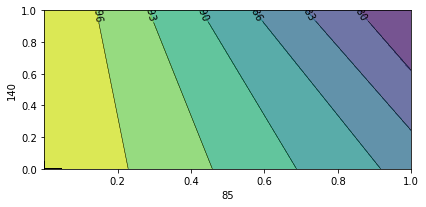

In [170]:
# logistic regression
# partial dependency plots

#for col in top_coefs_cols:
#features = top_coefs_cols[-5:]
features = [(85,140) ]
plot_partial_dependence(logr, X_train, features, target=4, n_jobs=-1, grid_resolution= 5) 



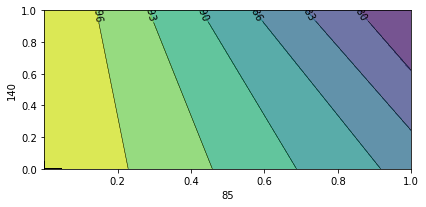

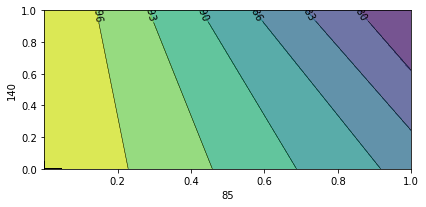

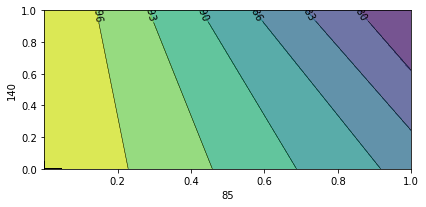

In [214]:
# logistic regression

features = [(85,140) ]
plot_partial_dependence(logr, X_train, features, target=3, n_jobs=-1, grid_resolution= 5) 
features = [(85,140) ]
plot_partial_dependence(logr, X_train, features, target=2, n_jobs=-1, grid_resolution= 5) 
features = [(85,140) ]
plot_partial_dependence(logr, X_train, features, target=1, n_jobs=-1, grid_resolution= 5) 

In [297]:
# gradient boosted classifier

gbc2 = GradientBoostingClassifier(loss='deviance', learning_rate=0.1, n_estimators=100,
                                random_state=659, verbose=1)

In [306]:
# %timeit
#gbc2.fit(X_train, y_train) - after 7 hours - still had 20 to go

In [ ]:
# with open('gbclrpoint01n_estimators1000_model.pkl', 'wb') as my_pickle:
#        pickle.dump(gbc2, my_pickle)

In [51]:
# logistic regression num in predicted classes, log loss of classes
# weight them based on cost of mis-predicting 0 as 4 bad 0 as 1 meh
def predicted_proba_metrics(ytest, xtest, model, class_labels):
    # takes fit model
    pp_class = []
    p_prob = model.predict_proba(xtest)
    yhat = model.predict(xtest)
    for num in model.classes_:
        print(f"for class {num} y:{len(ytest[ytest == num])} y_hat: {len(yhat[yhat == num])}")
        pp_class.append(p_prob[ytest == num])

    class_loss = []
    for num , probs in zip(model.classes_, pp_class):
        loss = log_loss((ytest[ytest == num]),probs, labels=class_labels)
        class_loss.append(loss)
        print(f"class {num} has log loss of {np.round(loss, 4)}")       

    logr_logloss = log_loss(y_test, p_prob)
    print(f"overall log loss: {logr_logloss}")
    return [class_loss, logr_logloss]

In [43]:
# make place to save results
proba_metrics = {}

In [78]:
type(logr.predict_proba(X_test))

numpy.ndarray

In [301]:
linr = LinearRegression()

In [302]:
#%timeit

linr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [305]:

gbr = GradientBoostingRegressor()
gbr.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='auto',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [309]:

gbr2 = GradientBoostingRegressor(random_state=659, learning_rate=0.01)
gbr2.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.01, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='auto',
                          random_state=659, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [310]:
'''with open('gbrbasic.pkl', 'wb') as my_pickle:
        pickle.dump(gbr, my_pickle)
with open('gbr_lr_01.pkl', 'wb') as my_pickle:
        pickle.dump(gbr2, my_pickle)'''

In [56]:
proba_metrics["logr"] = predicted_proba_metrics(y_test, X_test, logr, [0,1,2,3,4])

for class 0 y:407098 y_hat: 407126
for class 1 y:1794 y_hat: 2262
for class 2 y:589 y_hat: 128
for class 3 y:24 y_hat: 0
for class 4 y:19 y_hat: 8
class 0 has log loss of 0.0001
class 1 has log loss of 0.3265
class 2 has log loss of 1.4532
class 3 has log loss of 3.0654
class 4 has log loss of 1.9887
overall log loss: 0.003894521830373648


In [52]:
proba_metrics["gbc1"] = predicted_proba_metrics(y_test, X_test, gbc1, [0,1,2,3,4])

for class 0 y:407098 y_hat: 407191
for class 1 y:1794 y_hat: 947
for class 2 y:589 y_hat: 554
for class 3 y:24 y_hat: 770
for class 4 y:19 y_hat: 62
class 0 has log loss of 0.0004
class 1 has log loss of 19.835
class 2 has log loss of 23.5405
class 3 has log loss of 31.6605
class 4 has log loss of 34.5388
overall log loss: 0.12458063362592957


In [53]:
# random forest
proba_metrics["clf"] = predicted_proba_metrics(y_test, X_test, clf, [0,1,2,3,4])

for class 0 y:407098 y_hat: 409522
for class 1 y:1794 y_hat: 2
for class 2 y:589 y_hat: 0
for class 3 y:24 y_hat: 0
for class 4 y:19 y_hat: 0
class 0 has log loss of 0.0033
class 1 has log loss of 1.1459
class 2 has log loss of 2.2204
class 3 has log loss of 4.7708
class 4 has log loss of 4.6329
overall log loss: 0.011982994366389277


In [54]:
proba_metrics["gbc3"] = [0.0036770353709019927, [8.223825980389326e-05, 0.3061361946126585, 
                                                 1.3949131724950918,2.6528590081901595,1.993389169070535  ]]
                        
            

In [336]:
#logr_fi = logr.feature_importances_ 
gbc1_fi = gbc1.feature_importances_

indices = np.argsort(gbc1.feature_importances_)
big = indices[-1:-10:-1]

list(cols[big])


test = list(zip(gbc1.feature_importances_, cols_enumerate))
cols[big],

for int in big:
    print(cols_enumerate[int])

NameError: name 'cols_enumerate' is not defined

In [51]:
logr_top_col_names, logr_top_cols

(['SR_White',
  'ICT_Shots heard',
  'SR_Asian',
  'ICT_Suicidal person or attempts',
  'B_U3',
  'B_K1',
  'month_12',
  'ICT_Deadly Weapon - No Assault',
  'SG_Male',
  'SR_Black or African American'],
 [85, 140, 81, 142, 74, 47, 166, 108, 79, 82])

In [55]:
gbc1_yhat = gbc1.predict(X_test)

In [83]:
new_yhats = []
for y1, y2 in zip(logr_yhat, gbc1_yhat):
    new_yhats.append((y1+y2)/2)

In [84]:
mean_squared_error(y_test, new_yhats)
indicesy = y_test[y_test == 4]

type(new_yhats), np.array(new_yhats)[y_test == 4]

(list, array([1.5, 1. , 2. , 2. , 1. , 1. , 2.5, 2.5, 2.5, 3.5, 2.5, 1. , 2. ,
        2. , 2.5, 1. , 1. , 2. , 1. ]))

In [344]:
linr_yhat = linr.predict(X_test)
gbr_yhat = gbr.predict(X_test)
gbr2_yhat = gbr2.predict(X_test)

print(f"linear regression, score: {linr.score(X_test, y_test)} mse: {mean_squared_error(y_test, linr_yhat)}")
print(f"gradient boosted regression1, score: {gbr.score(X_test, y_test)} mse: {mean_squared_error(y_test, gbr_yhat)}")
print(f"gradient boosted regression2, score: {gbr2.score(X_test, y_test)} mse: {mean_squared_error(y_test, gbr2_yhat)}")
      
      

linear regression, score: 0.8484377835498818 mse: 0.0017195400307754211
gradient boosted regression1, score: 0.8670157771196543 mse: 0.0015087645196820863
gradient boosted regression2, score: 0.7380929555526012 mse: 0.0029714506545079505


In [363]:
gbr_yhat.min(), gbr_yhat.max(), gbr2_yhat.min(), gbr2_yhat.max(), linr_yhat.min(), linr_yhat.max()



(-0.044836547844088914,
 2.7571076175411187,
 0.0028287833343021975,
 1.0887301093554598,
 -0.14704066514968872,
 1.6041229292750359)

In [86]:
# create RFC model - change all but random_state after we time this one

#clf = RandomForestClassifier(n_estimators=100, max_depth=4, random_state=659, oob_score=True)

#with open('clf_model.pkl', 'wb') as my_pickle:
      #  pickle.dump(clf, my_pickle)

In [89]:
# check the feature importances and col_name list match first

len(clf.feature_importances_), len(cols)

(169, 169)

In [90]:
# most important features in predictions of this model

indices = np.argsort(clf.feature_importances_)
big = indices[-1:-10:-1]


list(cols[big])

['SG_Male',
 'SR_White',
 'SR_Black or African American',
 'SG_Female',
 'SR_Hispanic or Latino',
 'SR_Asian',
 'SR_American Indian/Alaska Native',
 'SR_Nat Hawaiian/Oth Pac Islander',
 'P_WEST']

In [91]:
# least important features
little = indices[:10]
cols[little]


Index(['ICT_Violation of Court Order (Not Domestic Violence)', 'B_FS', 'B_BS',
       'B_H2', 'B_H3', 'ICT_Sleeper Aboard Public Transit', 'B_N1', 'B_RS',
       'ICT_Rape', 'CT_IN PERSON COMPLAINT'],
      dtype='object')

In [ ]:
clf.oob_score_ # accuracy of training set

In [801]:
# predicted classes

yhat = clf.predict(X_test)

In [802]:
sum(yhat == y_test) / len(yhat) # accuracy of testing set

0.6723333333333333

In [803]:
# sklearn.metrics.classification_report(y_true, y_pred, labels=None, target_names=None, sample_weight=None, digits=2, output_dict=False)
print(classification_report(y_test, yhat))


              precision    recall  f1-score   support

           0       0.69      1.00      0.81      1219
           1       0.72      0.16      0.27      1217
           2       0.44      0.69      0.53      1175
           3       0.80      0.68      0.74      1196
           4       0.92      0.83      0.87      1193

    accuracy                           0.67      6000
   macro avg       0.71      0.67      0.65      6000
weighted avg       0.71      0.67      0.65      6000



In [804]:
# predict probabilities - what do you want threshold to be?

pp = clf.predict_proba(X_test)

In [811]:
# some rows' probabilities of being in each class:
# write function to truncate and set threshold

for p in pp[:10]:
    print(f"Probabilities: No Force: {np.round(p[0], 3)}, Force 1: {np.round(p[1], 3)}, Force 2: {np.round(p[2], 3)}, Force 3: {np.round(p[3], 3)}, Officer Involved Shooting: {np.round(p[4], 3)}")
          
          

Probabilities: No Force: 0.327, Force 1: 0.215, Force 2: 0.169, Force 3: 0.184, Officer Involved Shooting: 0.104
Probabilities: No Force: 0.131, Force 1: 0.198, Force 2: 0.19, Force 3: 0.366, Officer Involved Shooting: 0.115
Probabilities: No Force: 0.274, Force 1: 0.259, Force 2: 0.222, Force 3: 0.152, Officer Involved Shooting: 0.092
Probabilities: No Force: 0.08, Force 1: 0.122, Force 2: 0.113, Force 3: 0.101, Officer Involved Shooting: 0.584
Probabilities: No Force: 0.152, Force 1: 0.246, Force 2: 0.259, Force 3: 0.196, Officer Involved Shooting: 0.147
Probabilities: No Force: 0.381, Force 1: 0.185, Force 2: 0.183, Force 3: 0.168, Officer Involved Shooting: 0.083
Probabilities: No Force: 0.134, Force 1: 0.225, Force 2: 0.237, Force 3: 0.192, Officer Involved Shooting: 0.213
Probabilities: No Force: 0.07, Force 1: 0.064, Force 2: 0.045, Force 3: 0.037, Officer Involved Shooting: 0.782
Probabilities: No Force: 0.235, Force 1: 0.225, Force 2: 0.231, Force 3: 0.193, Officer Involved Sh

In [ ]:
# visualization - you can plot the abundance/frequency of each selected feature within each group as a bar plot. 
# I assume visually the top feature will be more abundant in one group comparing with the other groups.

four = y_test[y_test == 4]
four, four.index

In [92]:
models = [logr, clf, gbc1]

predicted_probas = []
lp = logr.predict_proba(X_train)
rp = clf.predict_proba(X_train)
gp = gbc1.predict_proba(X_train)
lp[0]

array([9.99983493e-01, 1.00454752e-05, 5.98844611e-06, 1.29748730e-08,
       4.60454423e-07])

In [95]:
# covariance

cov = EmpiricalCovariance().fit(X,y)

In [105]:
cc = pd.DataFrame(cov.covariance_)

In [134]:
cc.info()
cc[cc > 0.2]
np.where(cc < -0.5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 169 entries, 0 to 168
Columns: 169 entries, 0 to 168
dtypes: float64(169)
memory usage: 223.2 KB


(array([], dtype=int64), array([], dtype=int64))

In [102]:
cov.get_params()

{'assume_centered': False, 'store_precision': True}

In [4]:
big_coef_cols = [85, 140, 81, 142, 74, 47, 166, 108, 79, 82]

X2 = X.iloc[:,big_coef_cols]

In [7]:
cols[big_coef_cols]

Index(['SR_White', 'ICT_Shots heard', 'SR_Asian',
       'ICT_Suicidal person or attempts', 'B_U3', 'B_K1', 'month_12',
       'ICT_Deadly Weapon - No Assault', 'SG_Male',
       'SR_Black or African American'],
      dtype='object')

In [9]:
fl = sampleall.groupby("Force_Level")

(10, 10, 10)

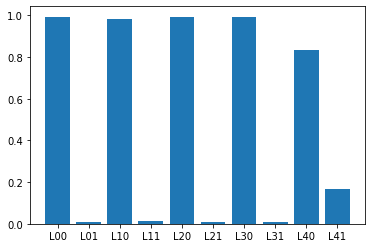

In [111]:
dw = fl['ICT_Suicidal person or attempts'].value_counts()
level00 = dw[0][0]
level01 = dw[0][1]

lst = dw.values[[0,1,2,3,4,5,6,7,8,9]]

lst_ones = dw.values[[1,3,5,8]]

lst_levels = ["L00", "L01","L10","L11","L20", "L21", "L30","L31", "L40", "L41"]

dw.index
dw.index.levels[1]
#plt.bar([0,1],dw[0].values)
#plt.bar(["01","10","11","20","21","30","40","41"],dw.values[[1,2,3,4,5,6,7,8]]);
plt.bar(lst_levels,a);

# divide by the total number in that category

a = [(lst[0]/ sum(dw[0])), (lst[1]/ sum(dw[0])), (lst[2]/ sum(dw[1])), (lst[3]/ sum(dw[1])),
     (lst[4]/ sum(dw[2])), (lst[5]/ sum(dw[2])), (lst[6]/ sum(dw[3])), (lst[7]/ sum(dw[3])),
     (lst[8]/ sum(dw[4])), (lst[9]/ sum(dw[4]))]
len(dw), len(lst_levels), len(a)

In [12]:
n = nm.groupby("Force_Level")

In [13]:
n.Subject_Race.value_counts()

Force_Level             Subject_Race                 
0                       -                                2035580
Level 1 - Use of Force  White                               3483
                        Black or African American           3086
                        Not Specified                       1574
                        Asian                                360
                        Hispanic or Latino                   338
                        American Indian/Alaska Native         66
                        Nat Hawaiian/Oth Pac Islander         46
Level 2 - Use of Force  White                               1222
                        Black or African American            996
                        Not Specified                        373
                        Asian                                108
                        Hispanic or Latino                    86
                        Nat Hawaiian/Oth Pac Islander         38
                        American Ind

In [10]:
X_test.shape

(409524, 169)

In [40]:
indices = np.argsort(gbc3.feature_importances_)
big = indices[-1:-10:-1]


list(cols[big])

['SG_Male',
 'SG_Female',
 'P_WEST',
 'SR_White',
 'S_MARY',
 'cos_hour2',
 'S_DAVID',
 'month_12',
 'sin_hour2']

In [57]:
proba_metrics

{'logr': [[0.00010263665088456779,
   0.3265427110075391,
   1.4532172330925373,
   3.0653699086953736,
   1.9887121638112204],
  0.003894521830373648],
 'gbc1': [[0.00037651295630981944,
   19.835020659757742,
   23.540517551342305,
   31.66054502866814,
   34.538776394910684],
  0.12458063362592957],
 'clf': [[0.003294532932389014,
   1.1459081863861342,
   2.220445775756719,
   4.770830438290839,
   4.632854651320371],
  0.011982994366389277],
 'gbc3': [0.0036770353709019927,
  [8.223825980389326e-05,
   0.3061361946126585,
   1.3949131724950918,
   2.6528590081901595,
   1.993389169070535]]}

In [61]:
import mord

In [62]:
mord_lit = mord.LogisticIT()

In [ ]:
mord.

In [66]:
%timeit

mord_lit.fit(X_train, y_train)

LogisticIT(alpha=1.0, max_iter=1000, verbose=0)

In [119]:
mord_IT = mord_lit.predict_proba(X_test)


In [68]:
predicted_proba_metrics(y_test, X_test, mord_lit, [0,1,2,3,4])

for class 0 y:407098 y_hat: 407126
for class 1 y:1794 y_hat: 2314
for class 2 y:589 y_hat: 84
for class 3 y:24 y_hat: 0
for class 4 y:19 y_hat: 0
class 0 has log loss of 0.0001
class 1 has log loss of 0.3522
class 2 has log loss of 1.8532
class 3 has log loss of 34.5388
class 4 has log loss of 2.9632
overall log loss: 0.006477453258413517


[[0.00010803422909235296,
  0.3522491956841416,
  1.8531832493422224,
  34.538776394910684,
  2.9632329055643383],
 0.006477453258413517]

In [267]:
bin2 = np.loadtxt("bin2logr_predict_proba")


In [268]:
bin3 = np.loadtxt("bin3gbc1_predicted_proba")
bin1 = np.loadtxt("logrbin_predict_proba.csv")

In [269]:
mord_AT = np.loadtxt("mord_AT")
# mord_IT

In [270]:
bin4 = np.loadtxt("bin4gbc3")
mord_SE = np.loadtxt("mord_SE")

In [277]:
bin10 = [x[0] for x in bin1]

In [ ]:
sampleall = pd.read_pickle("data/df_ready_to_split_to_X_y_no_day.pkl")

sa = sampleall.copy(deep=True)

X = sampleall.drop("Force_Level", axis=1)
y = sampleall.Force_Level

cols = X.columns

In [311]:


# Binarize the output
y = label_binarize(y, classes=[0, 1, 2, 3, 4])
n_classes = y.shape[1]

# Add noisy features to make the problem harder
#random_state = np.random.RandomState(0)
n_samples, n_features = X.shape
#X = np.c_[X, random_state.randn(n_samples, 200 * n_features)]

# shuffle and split training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2,
                                                    random_state=659)

In [312]:
y_score = logr.decision_function(X_test)


In [328]:
y_probs = logr.predict_proba(X_test)

In [323]:
y_test, y_score

(array([[1, 0, 0, 0, 0],
        [1, 0, 0, 0, 0],
        [1, 0, 0, 0, 0],
        ...,
        [1, 0, 0, 0, 0],
        [1, 0, 0, 0, 0],
        [1, 0, 0, 0, 0]]),
 array([[12.20278991,  0.2561508 , -2.9877074 , -4.38718242, -5.08405088],
        [12.56485782, -0.37691666, -0.96854024, -7.14604976, -4.07335115],
        [11.29684974,  0.52664067, -2.41422559, -4.07720812, -5.3320567 ],
        ...,
        [11.24305289, -0.59201723, -0.89635872, -5.06157755, -4.69309938],
        [ 9.64690039, -1.35628658, -2.00106908, -2.68872385, -3.60082087],
        [10.06570712, -0.43830425, -0.27357029, -2.42086379, -6.93296879]]))

In [329]:

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_probs[:, i])
    #print(fpr[i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

[0.        0.        0.        ... 0.9983512 0.9991756 1.       ]
[0.         0.         0.         ... 0.99998528 0.99999019 1.        ]
[0.         0.         0.         ... 0.99994376 0.99994865 1.        ]
[0.00000000e+00 0.00000000e+00 2.44200244e-06 ... 9.99982906e-01
 9.99992674e-01 1.00000000e+00]
[0.         0.         0.         ... 0.99994139 0.99999512 1.        ]


In [340]:
len(fpr[0])

73036

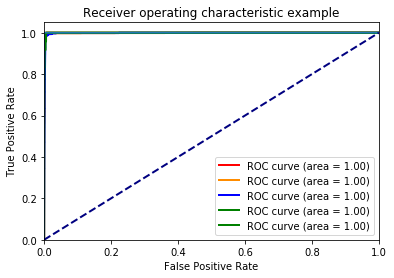

In [341]:
plt.figure()
lw = 2
plt.plot(fpr[0], tpr[0], color='red',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[0])
plt.plot(fpr[1], tpr[1], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[1])
plt.plot(fpr[2], tpr[2], color='blue',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[2])
plt.plot(fpr[3], tpr[3], color='green',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[3])
plt.plot(fpr[4], tpr[4], color='green',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[4])
plt.plot(fpr["micro"], tpr["micro"])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [279]:

roc_curve(y_true, bin10, pos_label=0)

(array([0.       , 0.       , 0.       , ..., 0.9983512, 0.9991756,
        1.       ]),
 array([0.00000000e+00, 2.45641099e-06, 1.22820549e-05, ...,
        1.00000000e+00, 1.00000000e+00, 1.00000000e+00]),
 array([1.99999986e+00, 9.99999862e-01, 9.99999828e-01, ...,
        7.20847425e-10, 5.06594793e-10, 1.68229559e-10]))

In [106]:
print(log_loss(y_true[y_true == 0], bin1[y_true == 0], labels=[0,1]))
print(log_loss(y_true[y_true == 1], bin1[y_true == 1], labels=[0,1]))


9.703465138657652e-05
0.06572117762392676


In [108]:
# bin2

y2_true = y_test.replace({1:0, 2:1, 3:1, 4:1})

log_loss(y2_true, bin2), y2_true.value_counts()

(0.003475163506268852, 0    408892
 1       632
 Name: Force_Level, dtype: int64)

In [112]:
print(log_loss(y2_true[y2_true == 0], bin2[y2_true == 0], labels=[0,1]))
print(log_loss(y2_true[y2_true == 1], bin2[y2_true == 1], labels=[0,1]))

0.001249710796405286
1.4433008113567953


In [111]:
# bin3

y3_true = y_test.replace({1:0, 2:0, 3:1, 4:1})

log_loss(y3_true, bin3), y3_true.value_counts()

(0.011548253292501419, 0    409481
 1        43
 Name: Force_Level, dtype: int64)

In [113]:
print(log_loss(y3_true[y3_true == 0], bin3[y3_true == 0], labels=[0,1]))
print(log_loss(y3_true[y3_true == 1], bin3[y3_true == 1], labels=[0,1]))

0.010775465454666225
7.3706630585155954


In [116]:
print(log_loss(y_test[y_test == 0], mord_AT[y_test == 0], labels=[0,1,2,3,4]))
print(log_loss(y_test[y_test == 1], mord_AT[y_test == 1], labels=[0,1,2,3,4]))
print(log_loss(y_test[y_test == 2], mord_AT[y_test == 2], labels=[0,1,2,3,4]))
print(log_loss(y_test[y_test == 3], mord_AT[y_test == 3], labels=[0,1,2,3,4]))
print(log_loss(y_test[y_test == 4], mord_AT[y_test == 4], labels=[0,1,2,3,4]))


0.0001402588537962934
0.3718107017721798
1.6626600251503743
3.988417963274076
4.297433821172463


In [117]:
proba_metrics["mord_AT"] = [log_loss(y_test, mord_AT), [log_loss(y_test[y_test == 0], mord_AT[y_test == 0], labels=[0,1,2,3,4]), log_loss(y_test[y_test == 1], mord_AT[y_test == 1], labels=[0,1,2,3,4]), log_loss(y_test[y_test == 2], mord_AT[y_test == 2], labels=[0,1,2,3,4]), log_loss(y_test[y_test == 3], mord_AT[y_test == 3], labels=[0,1,2,3,4]),log_loss(y_test[y_test == 4], mord_AT[y_test == 4], labels=[0,1,2,3,4]) ]
                        ]

In [128]:
# bin4
y4_true = y_test.replace({1:0,2:0,3:0, 4:1})
log_loss(y4_true, bin4), y4_true.value_counts()

(0.6103815568004803, 0    409505
 1        19
 Name: Force_Level, dtype: int64)

In [129]:
print(log_loss(y4_true[y4_true == 0], bin4[y4_true == 0], labels=[0,1]))
print(log_loss(y4_true[y4_true == 1], bin4[y4_true == 1], labels=[0,1]))


0.6100688214830621
7.350732933607379


In [130]:
# mord_SE
proba_metrics["mord_SE"] = [log_loss(y_test, mord_SE), [log_loss(y_test[y_test == 0], mord_SE[y_test == 0], labels=[0,1,2,3,4]), log_loss(y_test[y_test == 1], mord_SE[y_test == 1], labels=[0,1,2,3,4]), log_loss(y_test[y_test == 2], mord_SE[y_test == 2], labels=[0,1,2,3,4]), log_loss(y_test[y_test == 3], mord_SE[y_test == 3], labels=[0,1,2,3,4]),log_loss(y_test[y_test == 4], mord_SE[y_test == 4], labels=[0,1,2,3,4]) ]
                        ]

In [135]:
proba_metrics

{'logr': [[0.00010263665088456779,
   0.3265427110075391,
   1.4532172330925373,
   3.0653699086953736,
   1.9887121638112204],
  0.003894521830373648],
 'gbc1': [[0.00037651295630981944,
   19.835020659757742,
   23.540517551342305,
   31.66054502866814,
   34.538776394910684],
  0.12458063362592957],
 'clf': [[0.003294532932389014,
   1.1459081863861342,
   2.220445775756719,
   4.770830438290839,
   4.632854651320371],
  0.011982994366389277],
 'gbc3': [0.0036770353709019927,
  [8.223825980389326e-05,
   0.3061361946126585,
   1.3949131724950918,
   2.6528590081901595,
   1.993389169070535]],
 'mord_AT': [0.0045926674050274915,
  [0.0001402588537962934,
   0.3718107017721798,
   1.6626600251503743,
   3.988417963274076,
   4.297433821172463]],
 'mord_SE': [0.004792584187029591,
  [0.0002047840361124655,
   0.4141536458719966,
   1.6031119885576823,
   4.026563364619005,
   5.02362907211059]],
 'mord_IT': [0.006477453258413517,
  [0.00010803422909235296,
   0.3522491956841416,
   1.8

In [134]:
#mord_IT

proba_metrics["mord_IT"] = [log_loss(y_test, mord_IT), [log_loss(y_test[y_test == 0], mord_IT[y_test == 0], labels=[0,1,2,3,4]), log_loss(y_test[y_test == 1], mord_IT[y_test == 1], labels=[0,1,2,3,4]), log_loss(y_test[y_test == 2], mord_IT[y_test == 2], labels=[0,1,2,3,4]), log_loss(y_test[y_test == 3], mord_IT[y_test == 3], labels=[0,1,2,3,4]),log_loss(y_test[y_test == 4], mord_IT[y_test == 4], labels=[0,1,2,3,4]) ]]
                            
                            
                            
   

In [ ]:
bin1[0] = 0
bin2[0] - bin1[0] = 1
bin3[0] - bin2[0] = 2
bin4[0] - bin3[0] = 3
bin4[1] = 4



In [157]:
zero = bin1[y_true == 0]
ones = bin1[y_true == 1]
log_loss(y_test[y_test == 0], zero, labels=[0,1]), log_loss(y_true[y_true == 1], ones, labels=[0,1])



(9.703465138657652e-05, 0.06572117762392676)

In [153]:
one = bin2[(y2_true == 0) & (y_true != 0)]
log_loss(y_test[y_test == 1], one, labels=[0,1])

1.7463232921519256

In [150]:
len(y_test[y_test == 0]), len(y_test[y_test == 1]), len(y_test[y_test == 2]), len(y_test[y_test == 3]), len(y_test[y_test == 4])



(407098, 1794, 589, 24, 19)

In [155]:
four = bin4[y4_true == 1]
log_loss(y_test[y_test == 4], four, labels=[0,1])

11.02501646955589

In [2]:
sampleall = pd.read_pickle("data/df_ready_to_split_to_X_y_no_day.pkl")

In [13]:
list(sampleall.columns)
binX = sampleall.drop(['SG_Female',
 'SG_Male',
 'SR_American Indian/Alaska Native',
 'SR_Asian',
 'SR_Black or African American',
 'SR_Hispanic or Latino',
 'SR_Nat Hawaiian/Oth Pac Islander',
 'SR_White'], axis=1)

In [14]:
len(binX.columns)

162

In [16]:
X = binX.drop("Force_Level", axis=1)
y = binX.Force_Level
biny = y.replace({ 2:1, 3:1, 4:1})

In [95]:
logr_cols = list(X.columns)

with open ('logr_cols', 'wb') as lc:
        pickle.dump(logr_cols, lc)
        


In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, biny, test_size=0.2, random_state=659)

In [84]:
lrbimod = LogisticRegression(random_state=659, solver="saga", n_jobs=-1, verbose=1)


In [85]:
lrbimod.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


convergence after 41 epochs took 389 seconds


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:  6.5min finished


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=-1, penalty='l2',
                   random_state=659, solver='saga', tol=0.0001, verbose=1,
                   warm_start=False)

In [19]:
'''with open('lrbimod.pkl', 'wb') as my_pickle:
    pickle.dump(lrbimod, my_pickle)'''
    
with open('website/lrbimod.pkl', 'rb') as m:
    lrbimod = pickle.load(m)

In [20]:
pbimod = lrbimod.predict_proba(X_test)

In [88]:
fpr, tpr, _ = roc_curve(y_test, pbimod[:,0], pos_label=0)

In [89]:
roc_auc = auc(fpr, tpr)

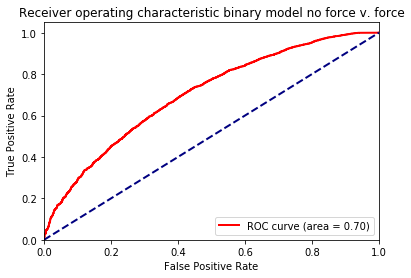

In [90]:

lw = 2
plt.plot(fpr, tpr, color='red',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic binary model no force v. force')
plt.legend(loc="lower right")

plt.savefig("ROC_curve_binary_logr.jpg")

In [91]:
log_loss(y_test, pbimod)

0.033775197239730916

In [18]:
pbimod

array([[9.99992677e-01, 7.32290067e-06],
       [9.99992420e-01, 7.57991499e-06],
       [9.99988138e-01, 1.18622701e-05],
       ...,
       [9.99986628e-01, 1.33721068e-05],
       [9.99990760e-01, 9.23996868e-06],
       [9.99992119e-01, 7.88116993e-06]])

In [21]:
gbc1234 = GradientBoostingClassifier(loss='deviance', learning_rate=0.1, n_estimators=1000,
                                random_state=659, verbose=1)

In [22]:
# use bin1 and then another classifier for 1-4
# redo bin1 without gender and race
sampleall = pd.read_pickle("data/df_ready_to_split_to_X_y_no_day.pkl")

indexNames = sampleall[ sampleall['Force_Level'] == 0 ].index
 
# Delete these row indexes from dataFrame
sa = sampleall.drop(indexNames )

In [7]:
with open('data/gbc1234.pkl', 'rb') as my_pickle:
    gbc1234 = pickle.load(my_pickle)


In [4]:
yll = sampleall.Force_Level
Xll = sampleall.drop("Force_Level", axis=1)

Xall_train, Xall_test, yall_train, yall_test = train_test_split(Xll, yll, test_size=0.2, random_state=659)

In [9]:
pgbc = gbc1234.predict_proba(Xall_test)

In [11]:
np.savetxt("pgbc", pgbc)

In [34]:
p_list = []
for r, s in zip(pbimod, pgbc):
   
    z = (r[0])
    o = (r[1]*s[0])
    tw = (r[1]*s[1])
    th = (r[1]*s[2])
    f = (r[1]*s[3])
    p_list.append(np.array([z,o,tw,th,f]))
    

In [39]:
len(p_list), len(yall_test)

(409524, 409524)

In [38]:
np.savetxt("p_list", p_list)

In [41]:
log_loss(yall_test, p_list, labels=[0, 1,2,3,4])

0.03553790990079508

In [59]:
p_arr = np.array([p_list])

In [63]:
type(pgbc[0]), type(p_arr[0]), type(pgbc), type(p_arr), p_arr[0].shape

(numpy.ndarray, numpy.ndarray, numpy.ndarray, numpy.ndarray, (409524, 5))

In [43]:
# Binarize the output
ybinall = label_binarize(yall_test, classes=[0, 1, 2,3,4])
n_classes = ybinall.shape[1]

In [64]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(ybinall[:, i], p_arr[0][:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(ybinall.ravel(), p_arr[0].ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

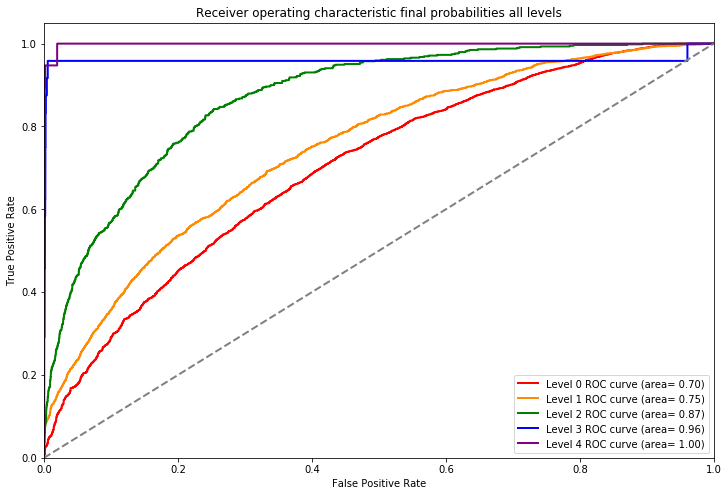

In [71]:
plt.figure(figsize=(12,8))
lw = 2
plt.plot(fpr[0], tpr[0], color='red',
         lw=lw, label='Level 0 ROC curve (area= %0.2f)' % roc_auc[0])
plt.plot(fpr[1], tpr[1], color='darkorange',
         lw=lw, label='Level 1 ROC curve (area= %0.2f)' % roc_auc[1])
plt.plot(fpr[2], tpr[2], color='green',
         lw=lw, label='Level 2 ROC curve (area= %0.2f)' % roc_auc[2])

plt.plot(fpr[3], tpr[3], color='blue',
         lw=lw, label='Level 3 ROC curve (area= %0.2f)' % roc_auc[3])
plt.plot(fpr[4], tpr[4], color='purple',
         lw=lw, label='Level 4 ROC curve (area= %0.2f)' % roc_auc[4])

plt.plot([0, 1], [0, 1], color='gray', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic final probabilities all levels')
plt.legend(loc="lower right");
plt.savefig("ROC_ALL.jpg")

In [96]:
sgr_cols = ['SG_Female',
    'SG_Male',
    'SR_American Indian/Alaska Native',
    'SR_Asian',
    'SR_Black or African American',
    'SR_Hispanic or Latino',
    'SR_Nat Hawaiian/Oth Pac Islander',
    'SR_White']

In [98]:
sgr_df = pd.DataFrame(np.zeros((1,8), dtype=np.float64), columns=sgr_cols)

In [100]:
with open('sgr_df.pkl', 'wb') as sgr:
    pickle.dump(sgr_df, sgr)